```
title: "Grewpy • request"
date: 2024-04-22
```

[`grewpy` Tutorial](../top)

# Grewpy tutorial: Run requests on a corpus


In [1]:
import grewpy
from grewpy import Corpus, Request

grewpy.set_config("sud") # ud or basic

connected to port: 49461


## Prepare data
The examples below suppose that the corpus `SUD_English-PUD` is available locally.
It can be downloaded from https://grew.fr/download/SUD_2.13/SUD_English-PUD.tgz

## Import data
The `Corpus` constructor takes a `conllu` file or a directory containing `conllu` files.
A `Corpus` allows to make queries and to count occurrences, 

Note that it doesn't allow a direct acces to the corpus. For that, use `CorpusDraft` object (TODO: add link)

In [2]:
treebank_path = "SUD_English-PUD"

corpus = Corpus(treebank_path)
print(type(corpus))

<class 'grewpy.corpus.Corpus'>


In [3]:
n_sentencens = len(corpus)
sent_ids = corpus.get_sent_ids()

print(f"{n_sentencens=}")
print(f"{sent_ids[0]=}")

n_sentencens=1000
sent_ids[0]='n01001011'


## Explore data
See [Grew-match tutorial](https://universal.grew.fr/?corpus=UD_English-ParTUT@2.13) to practice how to write Grew requests

### Count the number of subjets in the corpus

In [4]:
req1 = Request("X-[subj]->Y")
corpus.count(req1)

1420

### Count the number of subjects such that the subject's head is not a pronoun

In [5]:
req2 = Request("X-[subj]->Y").without("Y[upos=PRON]")
corpus.count(req2)

943

### Count the number of subjects with at least one dependant
Note the usage of `with_` (because `with` is a Python keyword)


In [6]:
req3 = Request("X-[subj]->Y").with_("Y->Z")
corpus.count(req3)

752

### with and without items can be stacked 


In [7]:
req4 = Request("X-[subj]->Y").with_("Y->Z").without("Y[upos=PRON]").without("X[upos=VERB]")
corpus.count(req4)

320

### Building a request with the raw Grew syntax
It is possible to build request directly from the concrete syntax used in Grew-match or in Grew rules, with the `parse` function.
The `req4` can be written:

In [8]:
req4bis = Request.parse("""
pattern { X-[subj]->Y }
with { Y->Z }
without { Y[upos=PRON] }
without { X[upos=VERB] }
""")
corpus.count(req4bis)

320

### More complex queries are allowed, with results clustering
See [Clustering](../../doc/clustering) for more documentation.
Below, we cluster the subject relation, according to the POS of the governor.

In [9]:
req5 = Request("X-[subj]->Y")
corpus.count(req5, clustering_parameter=["X.upos"])

{'VERB': 826, 'SCONJ': 1, 'PART': 5, 'NOUN': 3, 'AUX': 581, 'ADP': 3, 'ADJ': 1}

### Clustering results by other requests
The clustering is done on the relative position of `X` and `Y`.
It answers to the question: _How many subjects are in a pre-verbal position?_

In [10]:
req5 = Request("X-[subj]->Y")
corpus.count(req5, clustering_parameter=["{X << Y}"])

{'Yes': 77, 'No': 1343}

### Two clusterings can be applied

In [11]:
corpus.count(req5, clustering_parameter=["{X << Y}","X.upos"])

{'Yes': {'VERB': 45, 'SCONJ': 1, 'AUX': 30, 'ADP': 1},
 'No': {'VERB': 781, 'PART': 5, 'NOUN': 3, 'AUX': 551, 'ADP': 2, 'ADJ': 1}}

### More than two clusterings are also possible

In [12]:
corpus.count(req5, clustering_parameter=["{X << Y}","X.upos", "{X[Number=Sing]}"])

{'Yes': {'VERB': {'Yes': 16, 'No': 29},
  'SCONJ': {'No': 1},
  'AUX': {'Yes': 21, 'No': 9},
  'ADP': {'No': 1}},
 'No': {'VERB': {'Yes': 167, 'No': 614},
  'PART': {'No': 5},
  'NOUN': {'Yes': 2, 'No': 1},
  'AUX': {'Yes': 255, 'No': 296},
  'ADP': {'No': 2},
  'ADJ': {'No': 1}}}

### Search occurrences
Get the list of occurrence of a given request in the corpus

In [13]:
occurrences = corpus.search(req1)
assert len(occurrences) == corpus.count(req1)
occurrences[0]

{'sent_id': 'w05010027',
 'matching': {'nodes': {'Y': '8', 'X': '10'}, 'edges': {}}}

### Get occurrences including edges
The edge is named `e`, and the label of the dependency is reported in the output

In [14]:
req6 = Request("e: X->Y; X[upos=VERB]")
corpus.search(req6)[3]

{'sent_id': 'w05010027',
 'matching': {'nodes': {'Y': '12', 'X': '10'},
  'edges': {'e': {'source': '10',
    'label': {'1': 'comp', '2': 'obj'},
    'target': '12'}}}}

### As with `count`, we can cluster the results of a `search`

In [15]:
result = corpus.search(req6, clustering_parameter=["{X << Y}"])
result.keys()

dict_keys(['Yes', 'No'])

### Extras

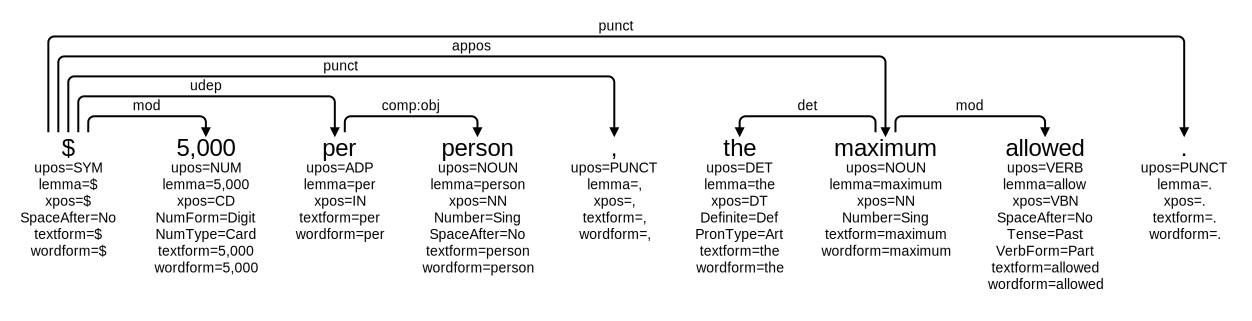

In [16]:
# Grewpy give access to svg or dot formats to display graphs
from IPython.display import display_svg

sentence = corpus[6]

g = sentence.to_svg() #.to_dot()
display_svg(g, raw=True)

In [17]:
# the conllu is easy to get of recover

conll_string= corpus.to_conll()
print(conll_string[:106])

# newdoc id = n01001
# sent_id = n01001011
# text = “While much of the digital transition is unprecedented


In [18]:
# Working with really big corpus could be a little bit painful. 
# To remove the corpus from memory use:
corpus.clean()

# Grew errors can be capture using:
grewpy.grew.GrewError("Oups!")

grewpy.grew.GrewError('Oups!')